In [2]:
import pandas as pd

def load_and_classify_routing_log(path):
    df = pd.read_csv(path)
    df.columns = [
        "Time", "Node", "Destination", "Previous_LifeTime", "New_LifeTime",
        "Previous_NextHop", "New_NextHop", "Previous_HopCount", "New_HopCount"
    ]
    df["HopChange"] = df["Previous_HopCount"] != df["New_HopCount"]
    df["NextHopChange"] = df["Previous_NextHop"] != df["New_NextHop"]
    df["LifeTimeChange"] = df["Previous_LifeTime"] != df["New_LifeTime"]
    df["ChangeType"] = df.apply(
        lambda row: "Hop+NextHop" if row["HopChange"] and row["NextHopChange"]
        else "HopOnly" if row["HopChange"]
        else "NextHopOnly" if row["NextHopChange"]
        else "LifeTimeOnly" if row["LifeTimeChange"]
        else "NoChange",
        axis=1
    )
    return df

def summarize_change_types(df):
    return df["ChangeType"].value_counts().sort_index()

def compare_change_type_stats(path_legacy, path_proposed):
    df_legacy = load_and_classify_routing_log(path_legacy)
    df_proposed = load_and_classify_routing_log(path_proposed)

    summary_legacy = summarize_change_types(df_legacy)
    summary_proposed = summarize_change_types(df_proposed)

    df_compare = pd.DataFrame({
        "Legacy": summary_legacy,
        "Proposed": summary_proposed
    }).fillna(0).astype(int)

    return df_compare

def estimate_rrep_success_rate(routing_log_path, recovery_log_path, change_type, interval=1.0):
    df = load_and_classify_routing_log(routing_log_path)
    changed_df = df[df["ChangeType"] == change_type][["Time", "Node", "Destination"]]

    recovery_df = pd.read_csv(recovery_log_path, header=None, names=["Time", "Node", "Destination", "Event"])
    rrep_df = recovery_df[recovery_df["Event"] == "RREP_RECV"]

    success = 0
    total = 0

    for _, row in changed_df.iterrows():
        t_start = row["Time"]
        t_end = t_start + interval
        dest = str(row["Destination"])

        matched = rrep_df[
            (rrep_df["Destination"].astype(str) == dest) &
            (rrep_df["Time"] >= t_start) & (rrep_df["Time"] <= t_end)
        ]

        total += 1
        if not matched.empty:
            success += 1

    rate = (success / total) * 100 if total > 0 else 0
    return rate

legacy_routing = "Legacy/aodv_routing_log.csv"
proposed_routing = "Proposed/aodv_routing_log.csv"
legacy_recovery = "Legacy/recovery_log.csv"
proposed_recovery = "Proposed/recovery_log.csv"

df_compare = compare_change_type_stats(legacy_routing, proposed_routing)
print("=== 변화 유형 통계 비교 ===")
print(df_compare)

print("\n=== RREP 수신률 비교 (변화 직후 1초 이내) ===")
change_types = ["Hop+NextHop", "HopOnly", "NextHopOnly"]

for change in change_types:
    legacy_rate = estimate_rrep_success_rate(legacy_routing, legacy_recovery, change)
    proposed_rate = estimate_rrep_success_rate(proposed_routing, proposed_recovery, change)

    print(f"[{change}]")
    print(f"  Legacy   : {legacy_rate:.2f}%")
    print(f"  Proposed : {proposed_rate:.2f}%\n")


=== 변화 유형 통계 비교 ===
              Legacy  Proposed
ChangeType                    
Hop+NextHop     1311      3958
HopOnly          288       661
LifeTimeOnly  675482    681442
NextHopOnly      934      2141

=== RREP 수신률 비교 (변화 직후 1초 이내) ===
[Hop+NextHop]
  Legacy   : 11.75%
  Proposed : 21.45%

[HopOnly]
  Legacy   : 18.06%
  Proposed : 30.11%

[NextHopOnly]
  Legacy   : 11.88%
  Proposed : 17.28%



In [ ]:
import bisect
import pandas as pd

def load_and_classify_routing_log(path):
    df = pd.read_csv(path)
    df.columns = [
        "Time", "Node", "Destination", "Previous_LifeTime", "New_LifeTime",
        "Previous_NextHop", "New_NextHop", "Previous_HopCount", "New_HopCount"
    ]
    df["HopChange"] = df["Previous_HopCount"] != df["New_HopCount"]
    df["NextHopChange"] = df["Previous_NextHop"] != df["New_NextHop"]
    df["LifeTimeChange"] = df["Previous_LifeTime"] != df["New_LifeTime"]
    df["ChangeType"] = df.apply(
        lambda row: "Hop+NextHop" if row["HopChange"] and row["NextHopChange"]
        else "HopOnly" if row["HopChange"]
        else "NextHopOnly" if row["NextHopChange"]
        else "LifeTimeOnly" if row["LifeTimeChange"]
        else "NoChange",
        axis=1
    )
    return df

def summarize_change_types(df):
    return df["ChangeType"].value_counts().sort_index()

def compare_change_type_stats(path_legacy, path_proposed):
    df_legacy = load_and_classify_routing_log(path_legacy)
    df_proposed = load_and_classify_routing_log(path_proposed)

    summary_legacy = summarize_change_types(df_legacy)
    summary_proposed = summarize_change_types(df_proposed)

    df_compare = pd.DataFrame({
        "Legacy": summary_legacy,
        "Proposed": summary_proposed
    }).fillna(0).astype(int)

    return df_compare

def estimate_rrep_success_rate_binary_search(
    routing_log_path, recovery_log_path, change_type="Hop+NextHop", interval=1.0
):
    df = load_and_classify_routing_log(routing_log_path)
    df = df[df["ChangeType"] == change_type][["Time", "Destination"]].copy()
    df["Destination"] = df["Destination"].astype(str)

    if df.empty:
        return 0.0

    recovery_df = pd.read_csv(recovery_log_path, header=None, names=["Time", "Node", "Destination", "Event"])
    rrep_df = recovery_df[recovery_df["Event"] == "RREP_RECV"][["Time", "Destination"]].copy()
    rrep_df["Destination"] = rrep_df["Destination"].astype(str)

    rrep_dict = {}
    for dest, group in rrep_df.groupby("Destination"):
        rrep_dict[dest] = sorted(group["Time"].tolist())

    total = len(df)
    success = 0

    for _, row in df.iterrows():
        t = row["Time"]
        d = row["Destination"]

        if d not in rrep_dict:
            continue

        times = rrep_dict[d]
        idx = bisect.bisect_left(times, t)
        if idx < len(times) and times[idx] <= t + interval:
            success += 1

    return (success / total) * 100 if total > 0 else 0


legacy_routing = "Legacy/aodv_routing_log.csv"
proposed_routing = "Proposed/aodv_routing_log.csv"
legacy_recovery = "Legacy/recovery_log.csv"
proposed_recovery = "Proposed/recovery_log.csv"

df_compare = compare_change_type_stats(legacy_routing, proposed_routing)
print("=== 변화 유형 통계 비교 ===")
print(df_compare)

print("\n=== RREP 수신률 비교 (변화 직후 1초 이내) ===")
change_types = ["Hop+NextHop", "HopOnly", "NextHopOnly"]

for change in change_types:
    legacy_rate = estimate_rrep_success_rate_binary_search(
        legacy_routing, legacy_recovery, change
    )
    proposed_rate = estimate_rrep_success_rate_binary_search(
        proposed_routing, proposed_recovery, change
    )

    print(f"[{change}]")
    print(f"  Legacy   : {legacy_rate:.2f}%")
    print(f"  Proposed : {proposed_rate:.2f}%\n")



=== 변화 유형 통계 비교 ===
              Legacy  Proposed
ChangeType                    
Hop+NextHop     1311      3958
HopOnly          288       661
LifeTimeOnly  675482    681442
NextHopOnly      934      2141

=== RREP 수신률 비교 (변화 직후 1초 이내) ===
[Hop+NextHop]
  Legacy   : 11.75%
  Proposed : 21.45%

[HopOnly]
  Legacy   : 18.06%
  Proposed : 30.11%

[NextHopOnly]
  Legacy   : 11.88%
  Proposed : 17.28%



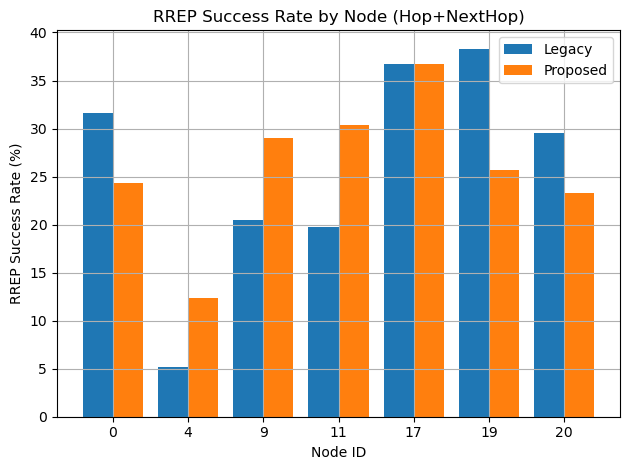

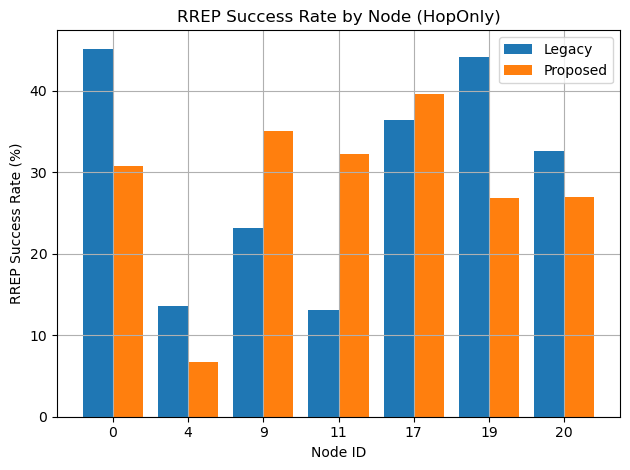

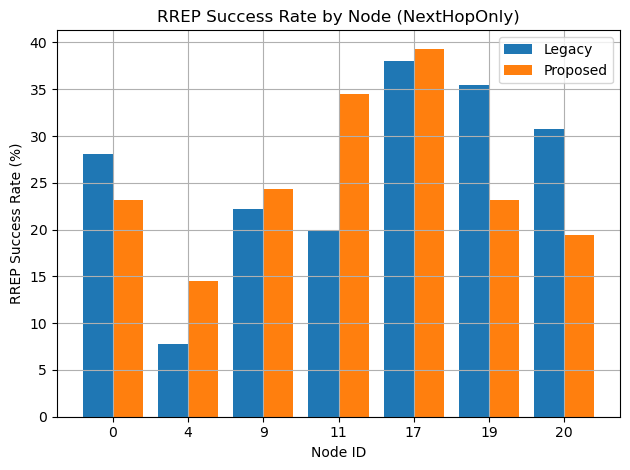

In [ ]:
import os
import bisect
import pandas as pd
import matplotlib.pyplot as plt

nodes = [0, 4, 6, 7, 9, 10, 11, 17, 19, 20]
change_types = ["Hop+NextHop", "HopOnly", "NextHopOnly"]
interval = 1.0

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/Lifetime 결과_V02/고밀도/고속/"

def load_and_classify_routing_log(path):
    df = pd.read_csv(path)
    df.columns = [
        "Time", "Node", "Destination", "Previous_LifeTime", "New_LifeTime",
        "Previous_NextHop", "New_NextHop", "Previous_HopCount", "New_HopCount"
    ]
    df["HopChange"] = df["Previous_HopCount"] != df["New_HopCount"]
    df["NextHopChange"] = df["Previous_NextHop"] != df["New_NextHop"]
    df["LifeTimeChange"] = df["Previous_LifeTime"] != df["New_LifeTime"]
    df["ChangeType"] = df.apply(
        lambda row: "Hop+NextHop" if row["HopChange"] and row["NextHopChange"]
        else "HopOnly" if row["HopChange"]
        else "NextHopOnly" if row["NextHopChange"]
        else "LifeTimeOnly" if row["LifeTimeChange"]
        else "NoChange",
        axis=1
    )
    return df

def estimate_rrep_success_rate(routing_log_path, recovery_log_path, change_type, interval):
    if not os.path.exists(routing_log_path) or not os.path.exists(recovery_log_path):
        return None

    df = load_and_classify_routing_log(routing_log_path)
    df = df[df["ChangeType"] == change_type][["Time", "Destination"]].copy()
    df["Destination"] = df["Destination"].astype(str)

    if df.empty:
        return 0.0

    recovery_df = pd.read_csv(recovery_log_path, header=None, names=["Time", "Node", "Destination", "Event"])
    rrep_df = recovery_df[recovery_df["Event"] == "RREP_RECV"][["Time", "Destination"]].copy()
    rrep_df["Destination"] = rrep_df["Destination"].astype(str)

    rrep_dict = {}
    for dest, group in rrep_df.groupby("Destination"):
        rrep_dict[dest] = sorted(group["Time"].tolist())

    total = len(df)
    success = 0

    for _, row in df.iterrows():
        t = row["Time"]
        d = row["Destination"]
        if d not in rrep_dict:
            continue
        times = rrep_dict[d]
        idx = bisect.bisect_left(times, t)
        if idx < len(times) and times[idx] <= t + interval:
            success += 1

    return (success / total) * 100 if total > 0 else 0.0

results = {change: [] for change in change_types}
valid_nodes = []

for node_id in nodes:
    legacy_routing = os.path.join(base_path, "기존", str(node_id), "aodv_routing_log.csv")
    legacy_recovery = os.path.join(base_path, "기존", str(node_id), "recovery_log.csv")
    proposed_routing = os.path.join(base_path, "제안", str(node_id), "aodv_routing_log.csv")
    proposed_recovery = os.path.join(base_path, "제안", str(node_id), "recovery_log.csv")

    if not all(map(os.path.exists, [legacy_routing, legacy_recovery, proposed_routing, proposed_recovery])):
        continue

    valid_nodes.append(node_id)

    for change in change_types:
        legacy_rate = estimate_rrep_success_rate(legacy_routing, legacy_recovery, change, interval)
        proposed_rate = estimate_rrep_success_rate(proposed_routing, proposed_recovery, change, interval)
        results[change].append((legacy_rate, proposed_rate))

for change in change_types:
    if change not in results or not results[change]:
        continue

    legacy_rates, proposed_rates = zip(*results[change])
    x = range(len(valid_nodes))
    plt.figure()
    plt.bar([i - 0.2 for i in x], legacy_rates, width=0.4, label="Legacy")
    plt.bar([i + 0.2 for i in x], proposed_rates, width=0.4, label="Proposed")
    plt.xticks(x, [str(n) for n in valid_nodes])
    plt.xlabel("Node ID")
    plt.ylabel("RREP Success Rate (%)")
    plt.title(f"RREP Success Rate by Node ({change})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [11]:
print("=== 변화 유형별 평균 RREP 수신률 ===")
for change in change_types:
    if not results[change]:
        continue
    legacy_rates, proposed_rates = zip(*results[change])
    avg_legacy = sum(legacy_rates) / len(legacy_rates)
    avg_proposed = sum(proposed_rates) / len(proposed_rates)
    print(f"[{change}]")
    print(f"  Legacy 평균   : {avg_legacy:.2f}%")
    print(f"  Proposed 평균 : {avg_proposed:.2f}%\n")


=== 변화 유형별 평균 RREP 수신률 ===
[Hop+NextHop]
  Legacy 평균   : 25.95%
  Proposed 평균 : 25.94%

[HopOnly]
  Legacy 평균   : 29.74%
  Proposed 평균 : 28.33%

[NextHopOnly]
  Legacy 평균   : 26.00%
  Proposed 평균 : 25.49%



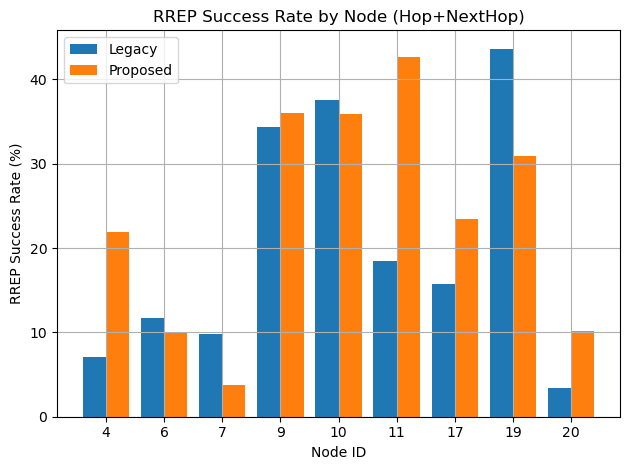

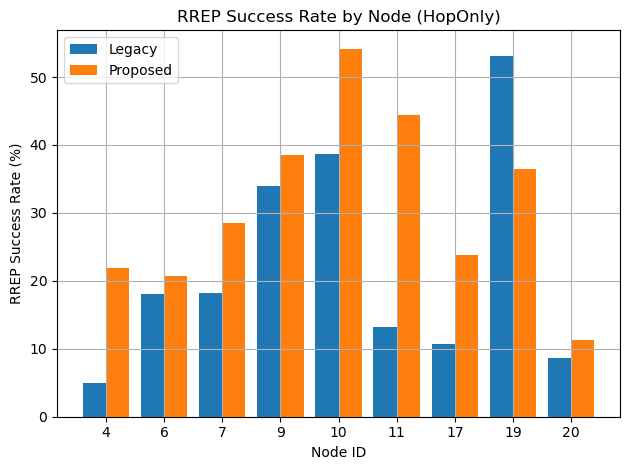

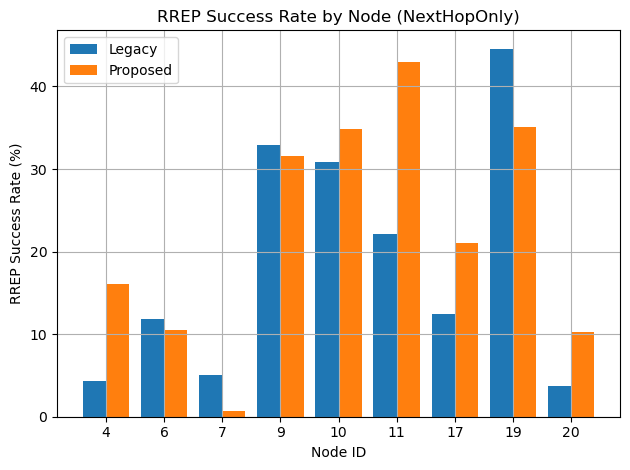

In [ ]:
import os
import bisect
import pandas as pd
import matplotlib.pyplot as plt

nodes = [0, 4, 6, 7, 9, 10, 11, 17, 19, 20]
change_types = ["Hop+NextHop", "HopOnly", "NextHopOnly"]
interval = 1.0

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/Lifetime 결과_V02/고밀도/중속/"

def load_and_classify_routing_log(path):
    df = pd.read_csv(path)
    df.columns = [
        "Time", "Node", "Destination", "Previous_LifeTime", "New_LifeTime",
        "Previous_NextHop", "New_NextHop", "Previous_HopCount", "New_HopCount"
    ]
    df["HopChange"] = df["Previous_HopCount"] != df["New_HopCount"]
    df["NextHopChange"] = df["Previous_NextHop"] != df["New_NextHop"]
    df["LifeTimeChange"] = df["Previous_LifeTime"] != df["New_LifeTime"]
    df["ChangeType"] = df.apply(
        lambda row: "Hop+NextHop" if row["HopChange"] and row["NextHopChange"]
        else "HopOnly" if row["HopChange"]
        else "NextHopOnly" if row["NextHopChange"]
        else "LifeTimeOnly" if row["LifeTimeChange"]
        else "NoChange",
        axis=1
    )
    return df

def estimate_rrep_success_rate(routing_log_path, recovery_log_path, change_type, interval):
    if not os.path.exists(routing_log_path) or not os.path.exists(recovery_log_path):
        return None

    df = load_and_classify_routing_log(routing_log_path)
    df = df[df["ChangeType"] == change_type][["Time", "Destination"]].copy()
    df["Destination"] = df["Destination"].astype(str)

    if df.empty:
        return 0.0

    recovery_df = pd.read_csv(recovery_log_path, header=None, names=["Time", "Node", "Destination", "Event"])
    rrep_df = recovery_df[recovery_df["Event"] == "RREP_RECV"][["Time", "Destination"]].copy()
    rrep_df["Destination"] = rrep_df["Destination"].astype(str)

    rrep_dict = {}
    for dest, group in rrep_df.groupby("Destination"):
        rrep_dict[dest] = sorted(group["Time"].tolist())

    total = len(df)
    success = 0

    for _, row in df.iterrows():
        t = row["Time"]
        d = row["Destination"]
        if d not in rrep_dict:
            continue
        times = rrep_dict[d]
        idx = bisect.bisect_left(times, t)
        if idx < len(times) and times[idx] <= t + interval:
            success += 1

    return (success / total) * 100 if total > 0 else 0.0

results = {change: [] for change in change_types}
valid_nodes = []

for node_id in nodes:
    legacy_routing = os.path.join(base_path, "기존", str(node_id), "aodv_routing_log.csv")
    legacy_recovery = os.path.join(base_path, "기존", str(node_id), "recovery_log.csv")
    proposed_routing = os.path.join(base_path, "제안", str(node_id), "aodv_routing_log.csv")
    proposed_recovery = os.path.join(base_path, "제안", str(node_id), "recovery_log.csv")

    if not all(map(os.path.exists, [legacy_routing, legacy_recovery, proposed_routing, proposed_recovery])):
        continue

    valid_nodes.append(node_id)

    for change in change_types:
        legacy_rate = estimate_rrep_success_rate(legacy_routing, legacy_recovery, change, interval)
        proposed_rate = estimate_rrep_success_rate(proposed_routing, proposed_recovery, change, interval)
        results[change].append((legacy_rate, proposed_rate))

for change in change_types:
    if change not in results or not results[change]:
        continue

    legacy_rates, proposed_rates = zip(*results[change])
    x = range(len(valid_nodes))
    plt.figure()
    plt.bar([i - 0.2 for i in x], legacy_rates, width=0.4, label="Legacy")
    plt.bar([i + 0.2 for i in x], proposed_rates, width=0.4, label="Proposed")
    plt.xticks(x, [str(n) for n in valid_nodes])
    plt.xlabel("Node ID")
    plt.ylabel("RREP Success Rate (%)")
    plt.title(f"RREP Success Rate by Node ({change})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


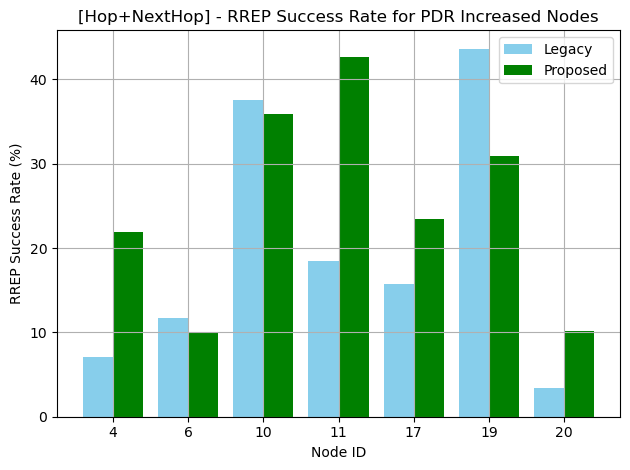

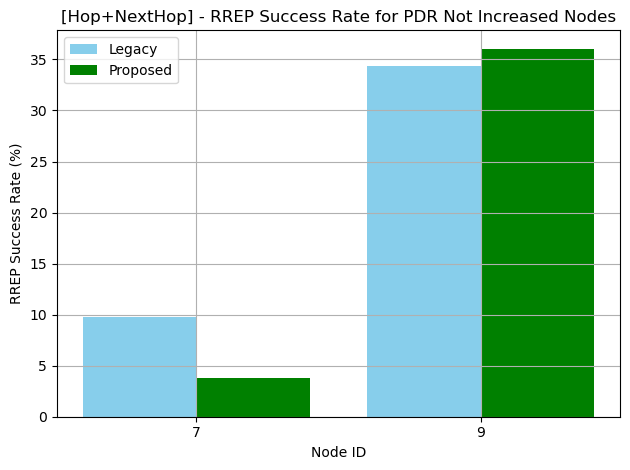

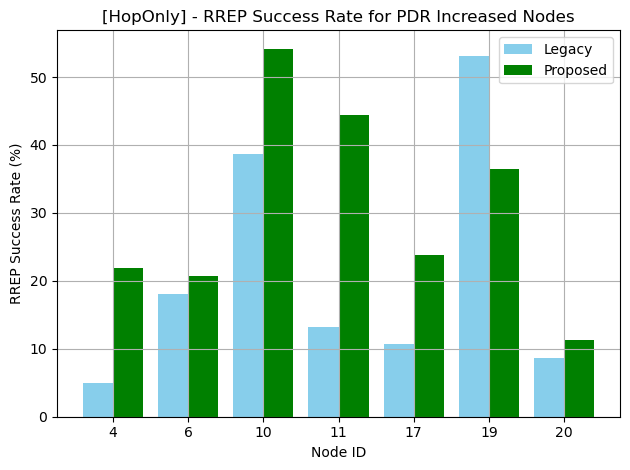

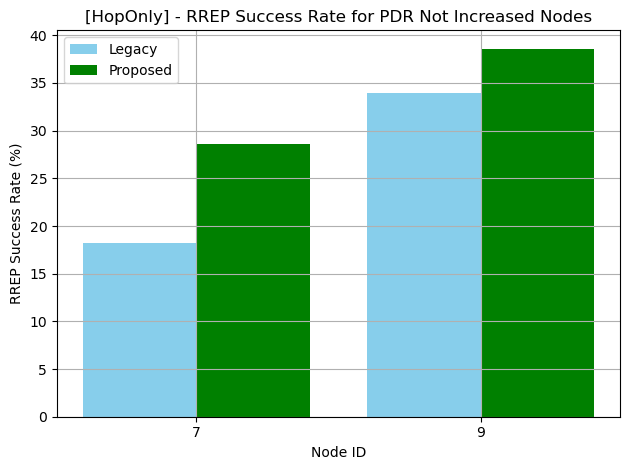

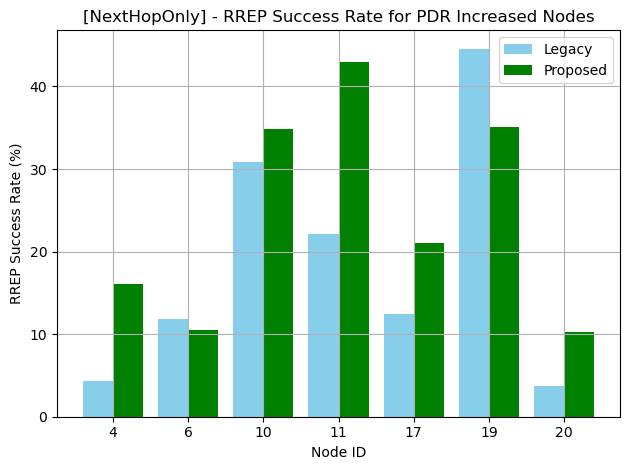

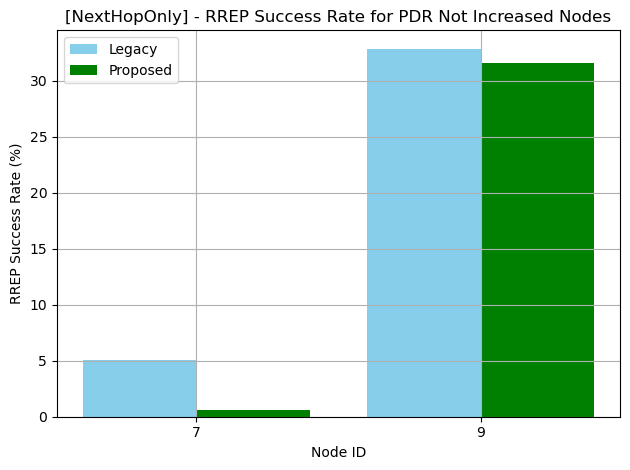

In [18]:
# PDR-based node grouping
pdr_data = {
    0: (71, 73),
    4: (84, 90),
    6: (46, 90),
    7: (98, 98),
    9: (71, 63),
    10: (69, 96),
    11: (79, 85),
    17: (74, 79),
    19: (53, 59),
    20: (88, 97),
}

# Grouping nodes based on PDR increase
pdr_increased = [n for n, (legacy, proposed) in pdr_data.items() if proposed > legacy]
pdr_not_increased = [n for n, (legacy, proposed) in pdr_data.items() if proposed <= legacy]

# Plot RREP success rate per change type and PDR group
for change in change_types:
    if change not in results or not results[change]:
        continue

    legacy_rates_all, proposed_rates_all = zip(*results[change])
    legacy_dict = dict(zip(valid_nodes, legacy_rates_all))
    proposed_dict = dict(zip(valid_nodes, proposed_rates_all))

    for group_name, group_nodes in [("PDR Increased", pdr_increased), ("PDR Not Increased", pdr_not_increased)]:
        group_legacy = [legacy_dict[n] for n in group_nodes if n in legacy_dict]
        group_proposed = [proposed_dict[n] for n in group_nodes if n in proposed_dict]
        group_valid = [n for n in group_nodes if n in legacy_dict and n in proposed_dict]
        if not group_valid:
            continue

        x = range(len(group_valid))
        plt.figure()
        plt.bar([i - 0.2 for i in x], group_legacy, width=0.4, label="Legacy", color='skyblue')
        plt.bar([i + 0.2 for i in x], group_proposed, width=0.4, label="Proposed", color='green')
        plt.xticks(x, [str(n) for n in group_valid])
        plt.xlabel("Node ID")
        plt.ylabel("RREP Success Rate (%)")
        plt.title(f"[{change}] - RREP Success Rate for {group_name} Nodes")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [13]:
print("=== 변화 유형별 평균 RREP 수신률 ===")
for change in change_types:
    if not results[change]:
        continue
    legacy_rates, proposed_rates = zip(*results[change])
    avg_legacy = sum(legacy_rates) / len(legacy_rates)
    avg_proposed = sum(proposed_rates) / len(proposed_rates)
    print(f"[{change}]")
    print(f"  Legacy 평균   : {avg_legacy:.2f}%")
    print(f"  Proposed 평균 : {avg_proposed:.2f}%\n")


=== 변화 유형별 평균 RREP 수신률 ===
[Hop+NextHop]
  Legacy 평균   : 20.18%
  Proposed 평균 : 23.84%

[HopOnly]
  Legacy 평균   : 22.18%
  Proposed 평균 : 31.10%

[NextHopOnly]
  Legacy 평균   : 18.65%
  Proposed 평균 : 22.58%



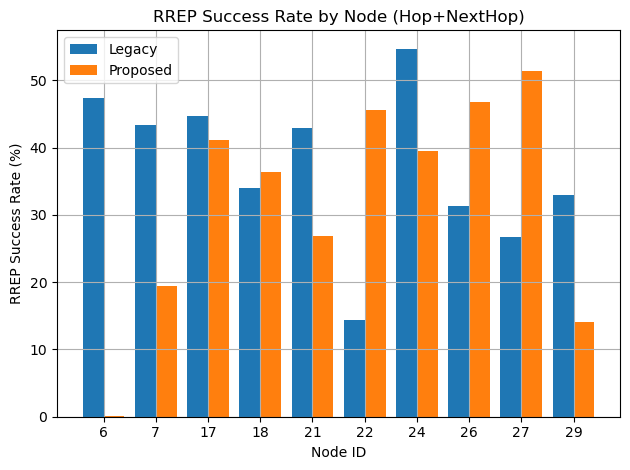

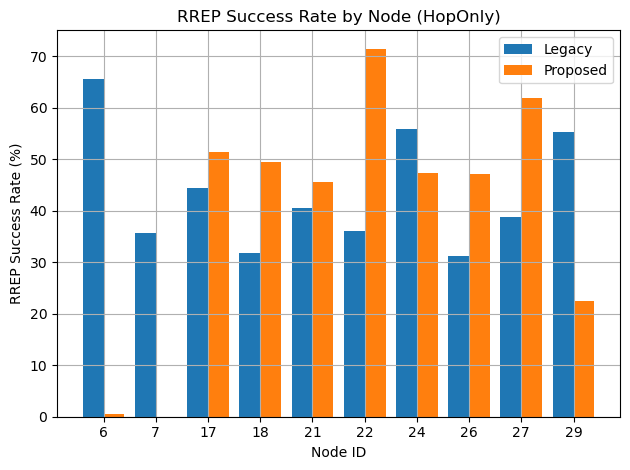

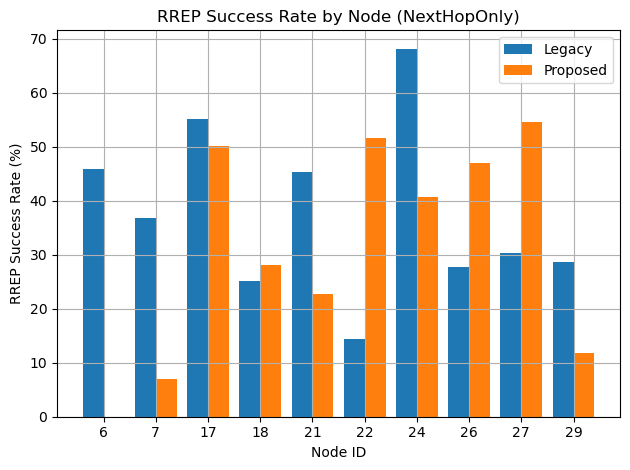

In [42]:
import os
import bisect
import pandas as pd
import matplotlib.pyplot as plt

xnodes = [0, 4, 6, 7, 9, 10, 11, 17, 19, 20]
nodes = [6, 7, 17, 18, 21, 22, 24, 26, 27, 29]

change_types = ["Hop+NextHop", "HopOnly", "NextHopOnly"]
interval = 3.0

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/Lifetime 결과_V02/중밀도/고속/"

def load_and_classify_routing_log(path):
    df = pd.read_csv(path)
    df.columns = [
        "Time", "Node", "Destination", "Previous_LifeTime", "New_LifeTime",
        "Previous_NextHop", "New_NextHop", "Previous_HopCount", "New_HopCount"
    ]
    df["HopChange"] = df["Previous_HopCount"] != df["New_HopCount"]
    df["NextHopChange"] = df["Previous_NextHop"] != df["New_NextHop"]
    df["LifeTimeChange"] = df["Previous_LifeTime"] != df["New_LifeTime"]
    df["ChangeType"] = df.apply(
        lambda row: "Hop+NextHop" if row["HopChange"] and row["NextHopChange"]
        else "HopOnly" if row["HopChange"]
        else "NextHopOnly" if row["NextHopChange"]
        else "LifeTimeOnly" if row["LifeTimeChange"]
        else "NoChange",
        axis=1
    )
    return df

def estimate_rrep_success_rate(routing_log_path, recovery_log_path, change_type, interval):
    if not os.path.exists(routing_log_path) or not os.path.exists(recovery_log_path):
        return None

    df = load_and_classify_routing_log(routing_log_path)
    df = df[df["ChangeType"] == change_type][["Time", "Destination"]].copy()
    df["Destination"] = df["Destination"].astype(str)

    if df.empty:
        return 0.0

    recovery_df = pd.read_csv(recovery_log_path, header=None, names=["Time", "Node", "Destination", "Event"])
    rrep_df = recovery_df[recovery_df["Event"] == "RREP_RECV"][["Time", "Destination"]].copy()
    rrep_df["Destination"] = rrep_df["Destination"].astype(str)

    rrep_dict = {}
    for dest, group in rrep_df.groupby("Destination"):
        rrep_dict[dest] = sorted(group["Time"].tolist())

    total = len(df)
    success = 0

    for _, row in df.iterrows():
        t = row["Time"]
        d = row["Destination"]
        if d not in rrep_dict:
            continue
        times = rrep_dict[d]
        idx = bisect.bisect_left(times, t)
        if idx < len(times) and times[idx] <= t + interval:
            success += 1

    return (success / total) * 100 if total > 0 else 0.0

results = {change: [] for change in change_types}
valid_nodes = []

for node_id in nodes:
    legacy_routing = os.path.join(base_path, "기존", str(node_id), "aodv_routing_log.csv")
    legacy_recovery = os.path.join(base_path, "기존", str(node_id), "recovery_log.csv")
    proposed_routing = os.path.join(base_path, "제안", str(node_id), "aodv_routing_log.csv")
    proposed_recovery = os.path.join(base_path, "제안", str(node_id), "recovery_log.csv")

    if not all(map(os.path.exists, [legacy_routing, legacy_recovery, proposed_routing, proposed_recovery])):
        continue

    valid_nodes.append(node_id)

    for change in change_types:
        legacy_rate = estimate_rrep_success_rate(legacy_routing, legacy_recovery, change, interval)
        proposed_rate = estimate_rrep_success_rate(proposed_routing, proposed_recovery, change, interval)
        results[change].append((legacy_rate, proposed_rate))

for change in change_types:
    if change not in results or not results[change]:
        continue

    legacy_rates, proposed_rates = zip(*results[change])
    x = range(len(valid_nodes))
    plt.figure()
    plt.bar([i - 0.2 for i in x], legacy_rates, width=0.4, label="Legacy")
    plt.bar([i + 0.2 for i in x], proposed_rates, width=0.4, label="Proposed")
    plt.xticks(x, [str(n) for n in valid_nodes])
    plt.xlabel("Node ID")
    plt.ylabel("RREP Success Rate (%)")
    plt.title(f"RREP Success Rate by Node ({change})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
std::ofstream outFile("data/dpc.txt", std::ios::app);
                outFile << dpc << std::endl;
                outFile.close();

In [41]:
print("\n=== RREP Success Rate Summary (%) ===")
for change in change_types:
    print(f"\n[ChangeType: {change}]")
    for i, node_id in enumerate(valid_nodes):
        legacy_rate, proposed_rate = results[change][i]
        print(f"Node {node_id:>2} | Legacy: {legacy_rate:6.2f}% | Proposed: {proposed_rate:6.2f}%")



=== RREP Success Rate Summary (%) ===

[ChangeType: Hop+NextHop]
Node  6 | Legacy:  22.83% | Proposed:   0.00%
Node  7 | Legacy:  27.76% | Proposed:  10.98%
Node 17 | Legacy:  29.21% | Proposed:  20.07%
Node 18 | Legacy:  17.54% | Proposed:   7.82%
Node 21 | Legacy:  24.40% | Proposed:  11.31%
Node 22 | Legacy:   8.44% | Proposed:  32.91%
Node 24 | Legacy:  43.98% | Proposed:  19.02%
Node 26 | Legacy:  17.34% | Proposed:  31.72%
Node 27 | Legacy:  20.27% | Proposed:  39.02%
Node 29 | Legacy:  21.88% | Proposed:   9.78%

[ChangeType: HopOnly]
Node  6 | Legacy:  43.70% | Proposed:   0.00%
Node  7 | Legacy:  35.71% | Proposed:   0.00%
Node 17 | Legacy:  32.18% | Proposed:  23.51%
Node 18 | Legacy:  28.05% | Proposed:  16.47%
Node 21 | Legacy:  31.82% | Proposed:  19.37%
Node 22 | Legacy:  22.67% | Proposed:  42.86%
Node 24 | Legacy:  40.54% | Proposed:  30.03%
Node 26 | Legacy:  18.75% | Proposed:  36.80%
Node 27 | Legacy:  33.33% | Proposed:  33.10%
Node 29 | Legacy:  32.08% | Proposed:

In [25]:
import os
import bisect
import pandas as pd
import matplotlib.pyplot as plt

nodes = [0, 4, 6, 7, 9, 10, 11, 17, 19, 20]
change_types = ["Hop+NextHop", "HopOnly", "NextHopOnly"]
base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/Lifetime 결과_V02/고밀도/저속/제안"

def preprocess_routing_log(path):
    df = pd.read_csv(path)
    df.columns = [
        "Time", "Node", "Destination", "Previous_LifeTime", "New_LifeTime",
        "Previous_NextHop", "New_NextHop", "Previous_HopCount", "New_HopCount"
    ]
    return df

def preprocess_recovery_log(path):
    return pd.read_csv(path, header=None, names=["Time", "Node", "Destination", "Event"])

def generate_change_events(routing_df):
    routing_df["HopChange"] = routing_df["Previous_HopCount"] != routing_df["New_HopCount"]
    routing_df["NextHopChange"] = routing_df["Previous_NextHop"] != routing_df["New_NextHop"]
    routing_df["LifeTimeChange"] = routing_df["Previous_LifeTime"] != routing_df["New_LifeTime"]
    routing_df["ChangeType"] = routing_df.apply(
        lambda row: "Hop+NextHop" if row["HopChange"] and row["NextHopChange"]
        else "HopOnly" if row["HopChange"]
        else "NextHopOnly" if row["NextHopChange"]
        else "LifeTimeOnly" if row["LifeTimeChange"]
        else "NoChange", axis=1
    )
    return routing_df[routing_df["ChangeType"] != "NoChange"][["Time", "Destination", "ChangeType"]]

def enrich_recovery_log(recovery_df, routing_df):
    changes = generate_change_events(routing_df)
    recovery_df["Destination"] = recovery_df["Destination"].astype(str)
    changes["Destination"] = changes["Destination"].astype(str)
    recovery_df["ChangeTime"] = None
    recovery_df["ChangeType"] = None
    for i, row in recovery_df.iterrows():
        dest = row["Destination"]
        time = row["Time"]
        related = changes[changes["Destination"] == dest]
        prior = related[related["Time"] <= time]
        if not prior.empty:
            last = prior.iloc[-1]
            recovery_df.at[i, "ChangeTime"] = last["Time"]
            recovery_df.at[i, "ChangeType"] = last["ChangeType"]
    return recovery_df

def calculate_avg_rrep_delay(recovery_df):
    df = recovery_df[(recovery_df["Event"] == "RREP_RECV") & (recovery_df["ChangeTime"].notnull())].copy()
    if df.empty:
        return None
    df["Delay"] = df["Time"] - df["ChangeTime"]
    return df["Delay"].mean()

def calculate_avg_pdr_recovery_time(recovery_df):
    if "DisconnectionTime" not in recovery_df.columns:
        return None
    df = recovery_df[(recovery_df["Event"] == "RREP_RECV") & (recovery_df["DisconnectionTime"].notnull())].copy()
    if df.empty:
        return None
    df["RecoveryDelay"] = df["Time"] - df["DisconnectionTime"]
    return df["RecoveryDelay"].mean()

def calculate_rrep_success_by_type(recovery_df):
    result = {}
    for change_type in change_types:
        subset = recovery_df[(recovery_df["ChangeType"] == change_type)]
        if len(subset) == 0:
            result[change_type] = None
        else:
            success = (subset["Event"] == "RREP_RECV").sum()
            result[change_type] = round((success / len(subset)) * 100, 2)
    return result

def count_lifetime_extensions(routing_df):
    routing_df["HopChanged"] = routing_df["Previous_HopCount"] != routing_df["New_HopCount"]
    routing_df["NextHopChanged"] = routing_df["Previous_NextHop"] != routing_df["New_NextHop"]
    routing_df["LifetimeExtended"] = routing_df["New_LifeTime"] > routing_df["Previous_LifeTime"]
    return routing_df[
        (routing_df["LifetimeExtended"]) &
        (~routing_df["HopChanged"]) &
        (~routing_df["NextHopChanged"])
    ].shape[0]

for node_id in nodes:
    routing_path = os.path.join(base_path, str(node_id), "aodv_routing_log.csv")
    recovery_path = os.path.join(base_path, str(node_id), "recovery_log.csv")

    if not os.path.exists(routing_path) or not os.path.exists(recovery_path):
        print(f"[Node {node_id}] 파일 없음 - 스킵함.")
        continue

    routing_df = preprocess_routing_log(routing_path)
    recovery_df = preprocess_recovery_log(recovery_path)
    recovery_df = enrich_recovery_log(recovery_df, routing_df)

    rrep_avg_delay = calculate_avg_rrep_delay(recovery_df)
    pdr_recov_time = calculate_avg_pdr_recovery_time(recovery_df)
    type_success = calculate_rrep_success_by_type(recovery_df)
    lifetime_exts = count_lifetime_extensions(routing_df)

    print(f"[Node {node_id}]")
    print(f"  ▸ Lifetime 연장 횟수 (Hop/NextHop 안 바뀐 경우): {lifetime_exts}")
    print(f"  ▸ 유형별 RREP 성공률: {type_success if type_success else '데이터 없음'}")
    print(f"  ▸ 평균 RREP 도착 지연: {rrep_avg_delay:.2f} sec" if rrep_avg_delay else "  ▸ RREP 지연 데이터 없음")
    print(f"  ▸ 평균 PDR 회복 지연: {pdr_recov_time:.2f} sec" if pdr_recov_time else "  ▸ PDR 회복 데이터 없음")
    print()


[Node 0]
  ▸ Lifetime 연장 횟수 (Hop/NextHop 안 바뀐 경우): 505039
  ▸ 유형별 RREP 성공률: {'Hop+NextHop': 90.05, 'HopOnly': 86.42, 'NextHopOnly': 90.42}
  ▸ 평균 RREP 도착 지연: 0.03 sec
  ▸ PDR 회복 데이터 없음

[Node 4]
  ▸ Lifetime 연장 횟수 (Hop/NextHop 안 바뀐 경우): 464214
  ▸ 유형별 RREP 성공률: {'Hop+NextHop': 90.32, 'HopOnly': 100.0, 'NextHopOnly': 66.67}
  ▸ 평균 RREP 도착 지연: 0.12 sec
  ▸ PDR 회복 데이터 없음

[Node 6]
  ▸ Lifetime 연장 횟수 (Hop/NextHop 안 바뀐 경우): 491705
  ▸ 유형별 RREP 성공률: {'Hop+NextHop': 89.21, 'HopOnly': 95.89, 'NextHopOnly': 86.73}
  ▸ 평균 RREP 도착 지연: 0.09 sec
  ▸ PDR 회복 데이터 없음

[Node 7]
  ▸ Lifetime 연장 횟수 (Hop/NextHop 안 바뀐 경우): 473042
  ▸ 유형별 RREP 성공률: {'Hop+NextHop': None, 'HopOnly': None, 'NextHopOnly': None}
  ▸ 평균 RREP 도착 지연: 0.16 sec
  ▸ PDR 회복 데이터 없음

[Node 9]
  ▸ Lifetime 연장 횟수 (Hop/NextHop 안 바뀐 경우): 531389
  ▸ 유형별 RREP 성공률: {'Hop+NextHop': 88.7, 'HopOnly': 89.59, 'NextHopOnly': 91.64}
  ▸ 평균 RREP 도착 지연: 0.04 sec
  ▸ PDR 회복 데이터 없음

[Node 10]
  ▸ Lifetime 연장 횟수 (Hop/NextHop 안 바뀐 경우): 473821
  ▸ 유형별 RREP 성공

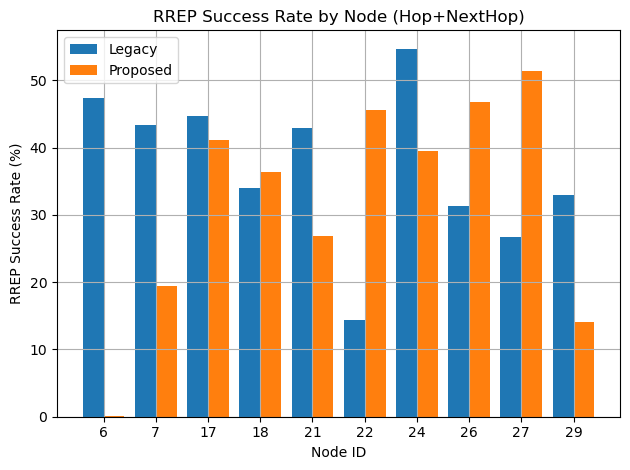

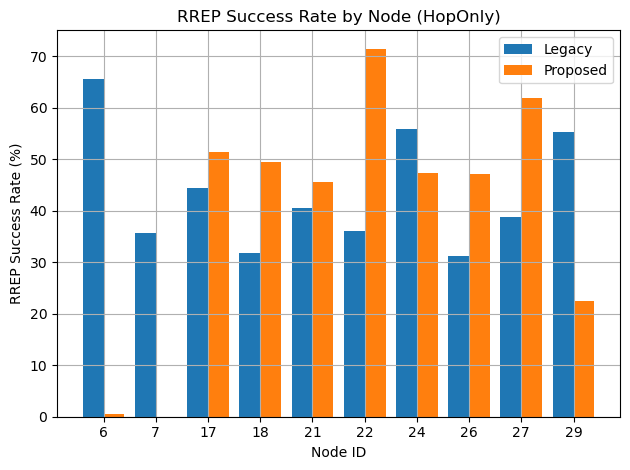

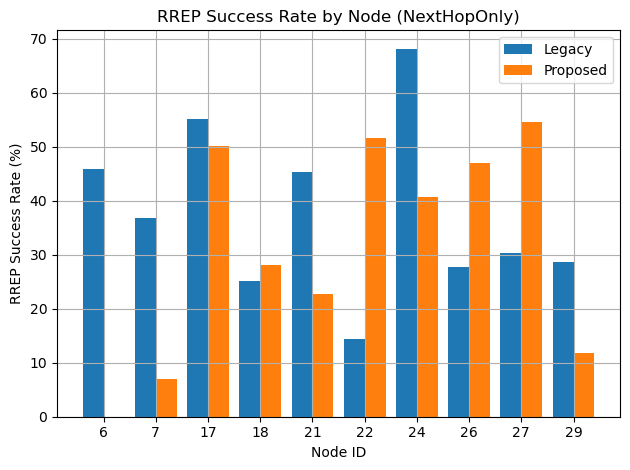

In [43]:
import os
import bisect
import pandas as pd
import matplotlib.pyplot as plt

xnodes = [0, 4, 6, 7, 9, 10, 11, 17, 19, 20]
nodes = [6, 7, 17, 18, 21, 22, 24, 26, 27, 29]

change_types = ["Hop+NextHop", "HopOnly", "NextHopOnly"]
interval = 3.0

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/Lifetime 결과_V02/중밀도/고속/"

def load_and_classify_routing_log(path):
    df = pd.read_csv(path)
    df.columns = [
        "Time", "Node", "Destination", "Previous_LifeTime", "New_LifeTime",
        "Previous_NextHop", "New_NextHop", "Previous_HopCount", "New_HopCount"
    ]
    df["HopChange"] = df["Previous_HopCount"] != df["New_HopCount"]
    df["NextHopChange"] = df["Previous_NextHop"] != df["New_NextHop"]
    df["LifeTimeChange"] = df["Previous_LifeTime"] != df["New_LifeTime"]
    df["ChangeType"] = df.apply(
        lambda row: "Hop+NextHop" if row["HopChange"] and row["NextHopChange"]
        else "HopOnly" if row["HopChange"]
        else "NextHopOnly" if row["NextHopChange"]
        else "LifeTimeOnly" if row["LifeTimeChange"]
        else "NoChange",
        axis=1
    )
    return df

def estimate_rrep_success_rate(routing_log_path, recovery_log_path, change_type, interval):
    if not os.path.exists(routing_log_path) or not os.path.exists(recovery_log_path):
        return None

    df = load_and_classify_routing_log(routing_log_path)
    df = df[df["ChangeType"] == change_type][["Time", "Destination"]].copy()
    df["Destination"] = df["Destination"].astype(str)

    if df.empty:
        return 0.0

    recovery_df = pd.read_csv(recovery_log_path, header=None, names=["Time", "Node", "Destination", "Event"])
    rrep_df = recovery_df[recovery_df["Event"] == "RREP_RECV"][["Time", "Destination"]].copy()
    rrep_df["Destination"] = rrep_df["Destination"].astype(str)

    rrep_dict = {}
    for dest, group in rrep_df.groupby("Destination"):
        rrep_dict[dest] = sorted(group["Time"].tolist())

    total = len(df)
    success = 0

    for _, row in df.iterrows():
        t = row["Time"]
        d = row["Destination"]
        if d not in rrep_dict:
            continue
        times = rrep_dict[d]
        idx = bisect.bisect_left(times, t)
        if idx < len(times) and times[idx] <= t + interval:
            success += 1

    return (success / total) * 100 if total > 0 else 0.0

results = {change: [] for change in change_types}
valid_nodes = []

for node_id in nodes:
    legacy_routing = os.path.join(base_path, "기존", str(node_id), "aodv_routing_log.csv")
    legacy_recovery = os.path.join(base_path, "기존", str(node_id), "recovery_log.csv")
    proposed_routing = os.path.join(base_path, "제안", str(node_id), "aodv_routing_log.csv")
    proposed_recovery = os.path.join(base_path, "제안", str(node_id), "recovery_log.csv")

    if not all(map(os.path.exists, [legacy_routing, legacy_recovery, proposed_routing, proposed_recovery])):
        continue

    valid_nodes.append(node_id)

    for change in change_types:
        legacy_rate = estimate_rrep_success_rate(legacy_routing, legacy_recovery, change, interval)
        proposed_rate = estimate_rrep_success_rate(proposed_routing, proposed_recovery, change, interval)
        results[change].append((legacy_rate, proposed_rate))

for change in change_types:
    if change not in results or not results[change]:
        continue

    legacy_rates, proposed_rates = zip(*results[change])
    x = range(len(valid_nodes))
    plt.figure()
    plt.bar([i - 0.2 for i in x], legacy_rates, width=0.4, label="Legacy")
    plt.bar([i + 0.2 for i in x], proposed_rates, width=0.4, label="Proposed")
    plt.xticks(x, [str(n) for n in valid_nodes])
    plt.xlabel("Node ID")
    plt.ylabel("RREP Success Rate (%)")
    plt.title(f"RREP Success Rate by Node ({change})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


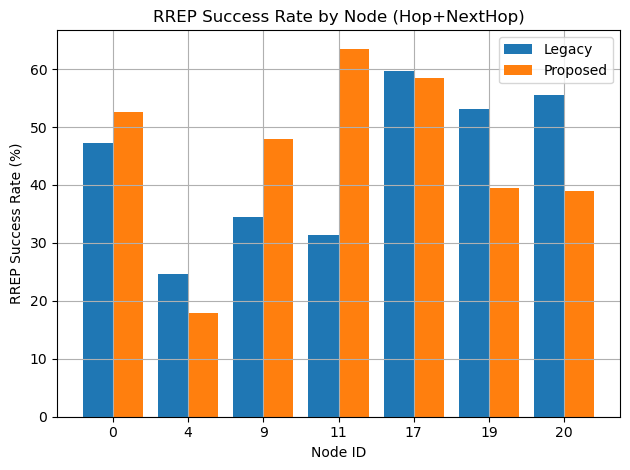

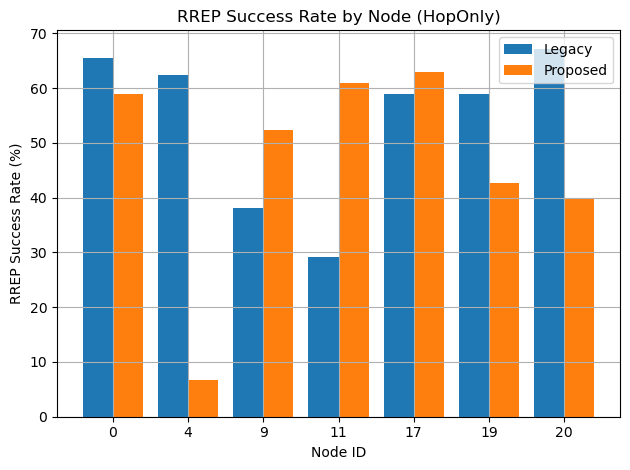

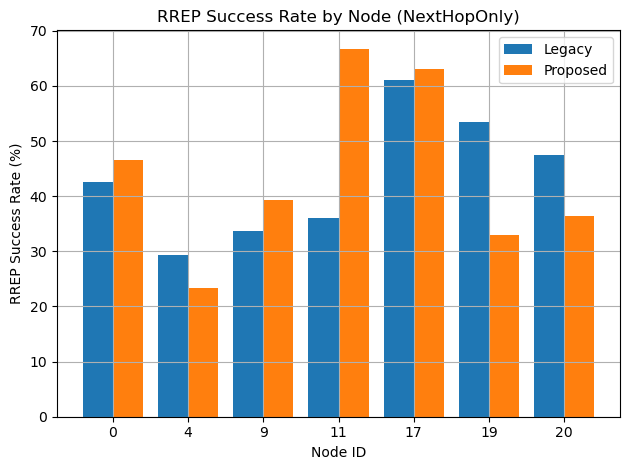

In [45]:
import os
import bisect
import pandas as pd
import matplotlib.pyplot as plt

nodes = [0, 4, 6, 7, 9, 10, 11, 17, 19, 20]
xnodes = [6, 7, 17, 18, 21, 22, 24, 26, 27, 29]

change_types = ["Hop+NextHop", "HopOnly", "NextHopOnly"]
interval = 3.0

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/Lifetime 결과_V02/고밀도/고속/"

def load_and_classify_routing_log(path):
    df = pd.read_csv(path)
    df.columns = [
        "Time", "Node", "Destination", "Previous_LifeTime", "New_LifeTime",
        "Previous_NextHop", "New_NextHop", "Previous_HopCount", "New_HopCount"
    ]
    df["HopChange"] = df["Previous_HopCount"] != df["New_HopCount"]
    df["NextHopChange"] = df["Previous_NextHop"] != df["New_NextHop"]
    df["LifeTimeChange"] = df["Previous_LifeTime"] != df["New_LifeTime"]
    df["ChangeType"] = df.apply(
        lambda row: "Hop+NextHop" if row["HopChange"] and row["NextHopChange"]
        else "HopOnly" if row["HopChange"]
        else "NextHopOnly" if row["NextHopChange"]
        else "LifeTimeOnly" if row["LifeTimeChange"]
        else "NoChange",
        axis=1
    )
    return df

def estimate_rrep_success_rate(routing_log_path, recovery_log_path, change_type, interval):
    if not os.path.exists(routing_log_path) or not os.path.exists(recovery_log_path):
        return None

    df = load_and_classify_routing_log(routing_log_path)
    df = df[df["ChangeType"] == change_type][["Time", "Destination"]].copy()
    df["Destination"] = df["Destination"].astype(str)

    if df.empty:
        return 0.0

    recovery_df = pd.read_csv(recovery_log_path, header=None, names=["Time", "Node", "Destination", "Event"])
    rrep_df = recovery_df[recovery_df["Event"] == "RREP_RECV"][["Time", "Destination"]].copy()
    rrep_df["Destination"] = rrep_df["Destination"].astype(str)

    rrep_dict = {}
    for dest, group in rrep_df.groupby("Destination"):
        rrep_dict[dest] = sorted(group["Time"].tolist())

    total = len(df)
    success = 0

    for _, row in df.iterrows():
        t = row["Time"]
        d = row["Destination"]
        if d not in rrep_dict:
            continue
        times = rrep_dict[d]
        idx = bisect.bisect_left(times, t)
        if idx < len(times) and times[idx] <= t + interval:
            success += 1

    return (success / total) * 100 if total > 0 else 0.0

results = {change: [] for change in change_types}
valid_nodes = []

for node_id in nodes:
    legacy_routing = os.path.join(base_path, "기존", str(node_id), "aodv_routing_log.csv")
    legacy_recovery = os.path.join(base_path, "기존", str(node_id), "recovery_log.csv")
    proposed_routing = os.path.join(base_path, "제안", str(node_id), "aodv_routing_log.csv")
    proposed_recovery = os.path.join(base_path, "제안", str(node_id), "recovery_log.csv")

    if not all(map(os.path.exists, [legacy_routing, legacy_recovery, proposed_routing, proposed_recovery])):
        continue

    valid_nodes.append(node_id)

    for change in change_types:
        legacy_rate = estimate_rrep_success_rate(legacy_routing, legacy_recovery, change, interval)
        proposed_rate = estimate_rrep_success_rate(proposed_routing, proposed_recovery, change, interval)
        results[change].append((legacy_rate, proposed_rate))

for change in change_types:
    if change not in results or not results[change]:
        continue

    legacy_rates, proposed_rates = zip(*results[change])
    x = range(len(valid_nodes))
    plt.figure()
    plt.bar([i - 0.2 for i in x], legacy_rates, width=0.4, label="Legacy")
    plt.bar([i + 0.2 for i in x], proposed_rates, width=0.4, label="Proposed")
    plt.xticks(x, [str(n) for n in valid_nodes])
    plt.xlabel("Node ID")
    plt.ylabel("RREP Success Rate (%)")
    plt.title(f"RREP Success Rate by Node ({change})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


   Node  제안_ext  제안_rrep_rate  제안_rrep_delay    기존_ext  기존_rrep_rate  \
0     0  702193         31.55           0.07       NaN           NaN   
1     4  676272         21.89           0.10  675273.0          7.04   
2     6  673208          9.92           0.65  675482.0         11.75   
3     9  763458         36.05           0.04  761960.0         34.38   
4    10  683982         35.84           0.05  671477.0         37.49   
5    11  699118         42.60           0.05  676599.0         18.45   
6    17  697808         23.48           0.03  707873.0         15.74   

   기존_rrep_delay  
0            NaN  
1           0.04  
2           0.09  
3           0.04  
4           0.11  
5           0.05  
6           0.02  


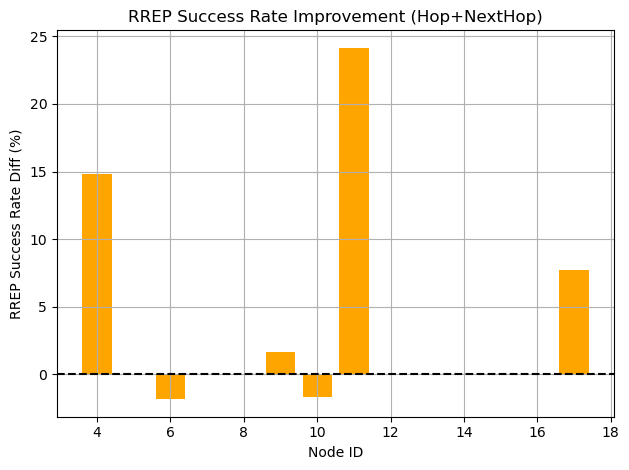

In [34]:
import os
import pandas as pd
import matplotlib.pyplot as plt

nodes = [0, 4, 6, 9, 10, 11, 17]
base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/Lifetime 결과_V02/고밀도/중속"

def load_routing(path):
    df = pd.read_csv(path)
    df.columns = [
        "Time", "Node", "Destination", "Previous_LifeTime", "New_LifeTime",
        "Previous_NextHop", "New_NextHop", "Previous_HopCount", "New_HopCount"
    ]
    return df

def load_recovery(path):
    return pd.read_csv(path, header=None, names=["Time", "Node", "Destination", "Event"])

def classify_change(routing_df):
    routing_df["HopChange"] = routing_df["Previous_HopCount"] != routing_df["New_HopCount"]
    routing_df["NextHopChange"] = routing_df["Previous_NextHop"] != routing_df["New_NextHop"]
    routing_df["LifeTimeChange"] = routing_df["Previous_LifeTime"] != routing_df["New_LifeTime"]
    routing_df["ChangeType"] = routing_df.apply(
        lambda row: "Hop+NextHop" if row["HopChange"] and row["NextHopChange"]
        else "HopOnly" if row["HopChange"]
        else "NextHopOnly" if row["NextHopChange"]
        else "LifeTimeOnly" if row["LifeTimeChange"]
        else "NoChange", axis=1
    )
    return routing_df

def count_lifetime_extensions(df):
    df = classify_change(df)
    cond = (df["ChangeType"] == "LifeTimeOnly")
    return df[cond].shape[0]

def rrep_success_rate(routing_df, recovery_df, change_type, interval=1.0):
    routing_df = classify_change(routing_df)
    target = routing_df[routing_df["ChangeType"] == change_type][["Time", "Destination"]].copy()
    if target.empty:
        return None

    recovery_df["Destination"] = recovery_df["Destination"].astype(str)
    target["Destination"] = target["Destination"].astype(str)

    rrep = recovery_df[recovery_df["Event"] == "RREP_RECV"]
    rrep_map = rrep.groupby("Destination")["Time"].apply(list).to_dict()

    success = 0
    for _, row in target.iterrows():
        t = row["Time"]
        d = row["Destination"]
        if d not in rrep_map:
            continue
        times = rrep_map[d]
        for rt in times:
            if t <= rt <= t + interval:
                success += 1
                break
    return (success / len(target)) * 100

def avg_rrep_delay(routing_df, recovery_df):
    routing_df = classify_change(routing_df)
    recovery_df["Destination"] = recovery_df["Destination"].astype(str)
    routing_df["Destination"] = routing_df["Destination"].astype(str)
    rrep = recovery_df[recovery_df["Event"] == "RREP_RECV"]

    delays = []
    for _, row in rrep.iterrows():
        dest = row["Destination"]
        time = row["Time"]
        related = routing_df[(routing_df["Destination"] == dest) & (routing_df["Time"] <= time)]
        if not related.empty:
            last = related.iloc[-1]
            delay = time - last["Time"]
            delays.append(delay)
    return sum(delays)/len(delays) if delays else None

compare = []

for node_id in nodes:
    result = {"Node": node_id}

    for mode in ["기존", "제안"]:
        r_path = os.path.join(base_path, mode, str(node_id), "aodv_routing_log.csv")
        rec_path = os.path.join(base_path, mode, str(node_id), "recovery_log.csv")

        if not (os.path.exists(r_path) and os.path.exists(rec_path)):
            continue

        routing = load_routing(r_path)
        recovery = load_recovery(rec_path)

        ext_count = count_lifetime_extensions(routing)
        rrep_rate = rrep_success_rate(routing, recovery, "Hop+NextHop")
        rrep_delay = avg_rrep_delay(routing, recovery)

        result[f"{mode}_ext"] = ext_count
        result[f"{mode}_rrep_rate"] = rrep_rate
        result[f"{mode}_rrep_delay"] = rrep_delay

    compare.append(result)

df = pd.DataFrame(compare)

pd.set_option('display.precision', 2)
print(df)

import matplotlib.pyplot as plt

df["RREP_rate_diff"] = df["제안_rrep_rate"] - df["기존_rrep_rate"]
plt.figure()
plt.bar(df["Node"], df["RREP_rate_diff"], color="orange")
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Node ID")
plt.ylabel("RREP Success Rate Diff (%)")
plt.title("RREP Success Rate Improvement (Hop+NextHop)")
plt.grid(True)
plt.tight_layout()
plt.show()


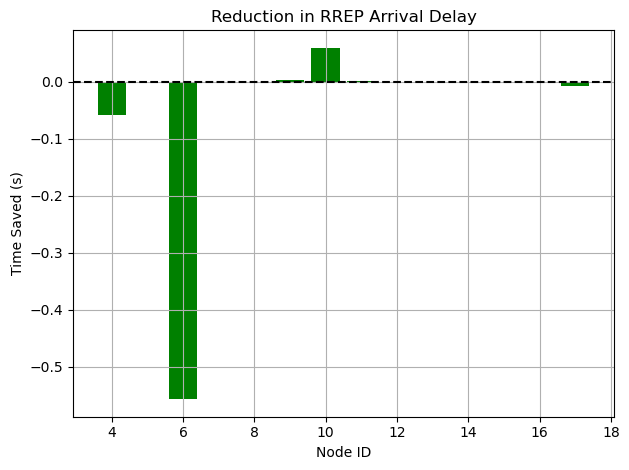

In [39]:
df["delay_diff"] = df["기존_rrep_delay"] - df["제안_rrep_delay"]

plt.figure()
plt.bar(df["Node"], df["delay_diff"], color="green")
plt.axhline(0, color="black", linestyle="--")
plt.title("Reduction in RREP Arrival Delay")
plt.xlabel("Node ID")
plt.ylabel("Time Saved (s)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [36]:
# 예시 데이터 (Node별)
node_ids = [0, 4, 6, 9, 10, 11, 17]
rrep_rate_diff = [2.7, 2.6, -12.1, -3.4, 0.5, -3.9, 27.1]  # 제안 - 기존
pdr_diff = [3.0, -2.0, -1.0, 11.0, 0.0, 0.0, 1.0]  # 제안 - 기존 PDR (%)


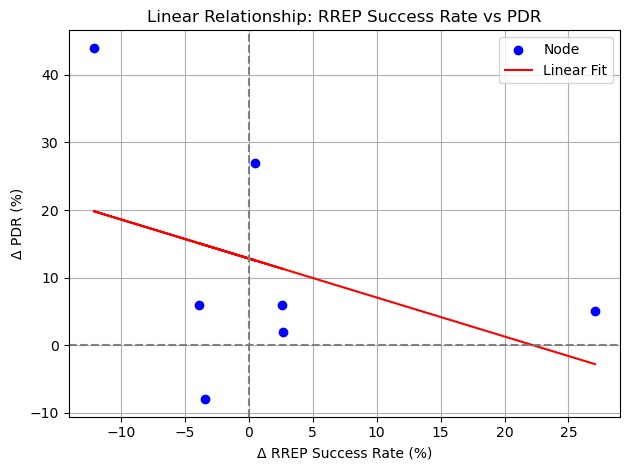

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# 노드 ID
nodes = [0, 4, 6, 9, 10, 11, 17]

# RREP 성공률 차이
rrep_diff = [2.68, 2.63, -12.13, -3.4, 0.52, -3.91, 27.07]

# PDR 차이
pdr_diff = [2, 6, 44, -8, 27, 6, 5]

# 선형 회귀
X = np.array(rrep_diff).reshape(-1, 1)
y = np.array(pdr_diff)
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# 그래프
plt.figure()
plt.scatter(rrep_diff, pdr_diff, color='blue', label='Node')
plt.plot(rrep_diff, y_pred, color='red', label='Linear Fit')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("Δ RREP Success Rate (%)")
plt.ylabel("Δ PDR (%)")
plt.title("Linear Relationship: RREP Success Rate vs PDR")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
